In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radcloud_encoder import RadCloudEncoder
from mmwave_model_integrator.model_runner.radcloud_runner import RadCloudRunner
from mmwave_model_integrator.decoders.radcloud_decoder import RadCloudDecoder
from mmwave_model_integrator.output_encoders.radcloud_lidar_encoder import RadCloudOutputEncoder
from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.plotting.movies_rng_az_to_pc import MovieGeneratorRngAzToPC
from mmwave_model_integrator.analyzers.analyzer_rng_az_to_pc import AnalyzerRngAzToPC
from mmwave_model_integrator.transforms.coordinate_transforms import polar_to_cartesian


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadCloud.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
dataset_folder = "WILK"
dataset_name = "WILK_1"
dataset_path = os.path.join(DATASET_PATH,"radCloud_comp_datasets",dataset_folder,dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 1101 radar samples
found 1101 lidar samples
found 1101 camera samples
found 1101 imu (orientation only) samples
found 1101imu (full data) samples
found 1101 vehicle velocity samples


In [4]:
plotter = PlotterRngAzToPC()

input_encoder = RadCloudEncoder(
    config_manager=cfg_manager,
    max_range_bin=64,
    num_chirps_to_encode=40,
    radar_fov_rad= [-0.87,0.87],
    num_az_angle_bins=64,
    power_range_dB=[60,105]
)

ground_truth_encoder = RadCloudOutputEncoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],#[-np.pi/2 - 0.87,-np.pi/2 + 0.87],
    num_angle_bins=48,
    num_previous_frames=0
)

runner = RadCloudRunner(
    state_dict_path=RADCLOUD_MODEL_STATE_DICT_PATH,
    cuda_device="cuda:0"
)

prediction_decoder = RadCloudDecoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],#[-np.pi/2 - 0.87,-np.pi/2 + 0.87],
    num_angle_bins=48
)

movie_generator = MovieGeneratorRngAzToPC(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_az_encoder=input_encoder,
    model_runner=runner,
    lidar_pc_polar_decoder=prediction_decoder,
    lidar_pc_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("MOVIE_TEMP_DIRECTORY")
)

analyzer = AnalyzerRngAzToPC(
    cpsl_dataset=dataset,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
)

_ModelRunner: using CPU
found temp dir: /home/cpsl/Downloads/radnav_temp_dir
clearing temp directory /home/cpsl/Downloads/radnav_temp_dir


In [5]:
#evaluating the model on standard inputs
# for i in tqdm(range(50)):
adc_cube = dataset.get_radar_data(idx=0)
rng_az_resp = input_encoder.encode(adc_cube)
pred = runner.make_prediction(input=rng_az_resp)
pc = prediction_decoder.convert_polar_to_cartesian(
    prediction_decoder.decode(pred)
)

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx=0)
grid = ground_truth_encoder.encode(lidar_pc)
quantized_pc = ground_truth_encoder.grid_to_polar_points(grid)
quantized_pc = polar_to_cartesian(quantized_pc)

print("pred shape", pred.shape)
print("pc shape", pc.shape)
print(pred[30])

torch.Size([1, 40, 64, 48])
pred shape (64, 48)
pc shape (75, 2)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
from mmwave_model_integrator.model_runner.vino_runner import VinoRunner

vino_runner = VinoRunner(
    state_dict_path=RADCLOUD_MODEL_STATE_DICT_PATH,
    cuda_device="cuda:0"
)

newvino
_ModelRunner: using CPU


RuntimeError: Exception from src/inference/src/cpp/core.cpp:104:
Exception from src/inference/src/dev/core_impl.cpp:566:
Device with "cpu" name is not registered in the OpenVINO Runtime



In [9]:
pred_vino = vino_runner.make_prediction(input=rng_az_resp)

print(pred_vino.shape)
print(pred_vino)

pc_vino = prediction_decoder.convert_polar_to_cartesian(
    prediction_decoder.decode(pred_vino)
)

print(pc_vino.shape)
print(pred[30])

for i in tqdm(range(100)):
    adc_cube = dataset.get_radar_data(idx=i)
    rng_az_resp = input_encoder.encode(adc_cube)
    pred = vino_runner.make_prediction(input=rng_az_resp)
    pc = prediction_decoder.convert_polar_to_cartesian(
        prediction_decoder.decode(pred)
    )

(64, 48)
[[0.5176928  0.5175861  0.5176166  ... 0.5179976  0.5176318  0.5179976 ]
 [0.5184091  0.51808906 0.51825666 ... 0.51833284 0.5179671  0.51837856]
 [0.5181195  0.5181348  0.5176471  ... 0.5176928  0.51793665 0.5180128 ]
 ...
 [0.5181805  0.51770806 0.5174795  ... 0.5175252  0.5175861  0.51778424]
 [0.5181348  0.51798236 0.5181348  ... 0.51843953 0.5185919  0.51821095]
 [0.5186833  0.5189576  0.519049   ... 0.51910996 0.51894236 0.5185767 ]]
(3072, 2)
[0.5179519  0.5176014  0.5173728  0.5173118  0.517388   0.51729655
 0.51729655 0.5173118  0.5173271  0.5173118  0.517388   0.51743376
 0.5175404  0.5176014  0.51770806 0.5177995  0.5178605  0.5178605
 0.5178605  0.5179062  0.5177995  0.5177995  0.5177385  0.5176623
 0.5176014  0.5175252  0.51744896 0.5174947  0.51743376 0.51740324
 0.5174185  0.5174947  0.5174795  0.5176776  0.5176928  0.51782995
 0.5179062  0.5179671  0.5180281  0.5181805  0.51825666 0.51837856
 0.51815    0.5181805  0.5181805  0.51810426 0.51833284 0.5181957 ]


100%|██████████| 100/100 [00:04<00:00, 23.93it/s]


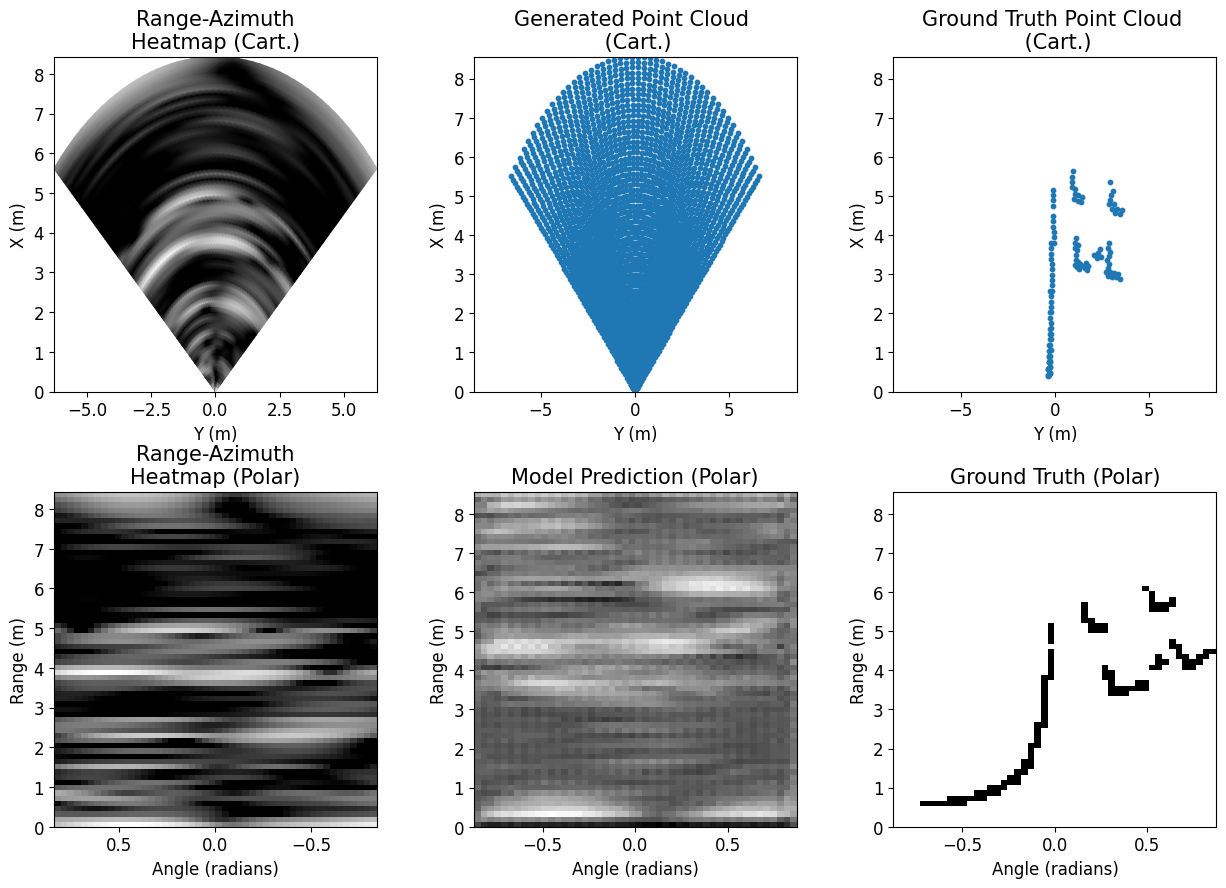

In [8]:
plotter.plot_compilation(
    adc_cube=adc_cube,
    range_az_encoder=input_encoder,
    model_runner=vino_runner,
    lidar_pc_polar_decoder=prediction_decoder,
    lidar_pc=lidar_pc,
    lidar_pc_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

In [ ]:
chamfer_alt,hausdorff_alt, chamfer_radCloud, modified_hausdorff_radCloud = \
    analyzer._compute_distance_metrics(sample_idx=0,print_result=True)

Chamfer: 0.7361327945227402, Hausdorff: 2.2416141213072693


  1%|          | 7/1101 [00:08<22:28,  1.23s/it]


KeyboardInterrupt: 

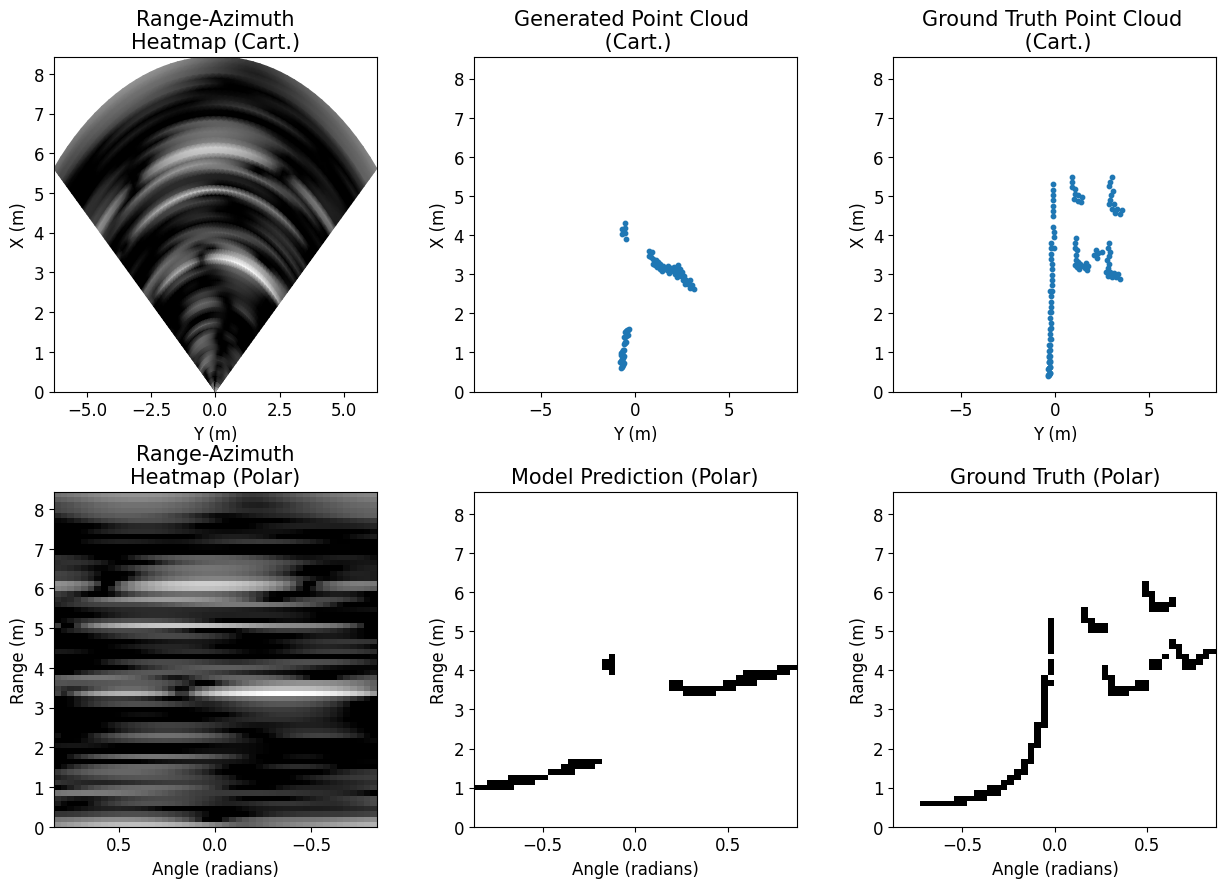

In [ ]:
movie_generator.initialize_figure(
    nrows=2,
    ncols=3,
    figsize=(15,10),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}.mp4".format(dataset_name),fps=fps)

In [1]:
import torch
import torchvision

In [10]:
resnet50 = torchvision.models.resnet50(torchvision.models.ResNet50_Weights.DEFAULT)
sample_inputs = [torch.randn(1, 3, 224, 224) for _ in range(100)]

/home/cpsl/.cache/pypoetry/virtualenvs/mmwave-model-integrator-Zyebo4p7-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [11]:
weights = torchvision.models.quantization.ResNet50_QuantizedWeights.DEFAULT

resnet50_quantized = torchvision.models.quantization.resnet50(weights=weights, quantize=True)

RuntimeError: Quantized backend not supported 

In [4]:
from tqdm import tqdm

for i in tqdm(sample_inputs):
    outputs = resnet18(i)

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]
